In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime
import itertools
from datetimerange import DateTimeRange
import pickle
import json
import sqlalchemy
from sqlalchemy.sql import text
import matplotlib.ticker as mtick

In [2]:
os.chdir('/home/candela/Documents/greeneHill/membershipReportsCIVI')

In [5]:
sql = '''
WITH trial_conversions AS (
select cast(JSON_EXTRACT(latest_trial2, '$.start_dt') as date) trial_date, cast(start_dt as date) status_date, 
datediff(cast(start_dt as date), cast(JSON_EXTRACT(latest_trial2, '$.start_dt') as date)) as date_difference,
email, type_clean
from mem_type_0927
where (type_clean not like '%%trial%%' AND type_clean not like '%%bushwick%%' AND type_clean not like '%%park%%')
AND cast(JSON_EXTRACT(latest_trial2, '$.start_dt')as date) is not null),
all_trials AS (
select cast(start_dt as date) status_date, email, type_clean
from mem_type_0927
where type_clean like '%%trial%%'),
conversion_agg AS (
select date_format(trial_date, '%%Y-%%m') as month, count(distinct email) as converted_cnt
from trial_conversions 
group by 1),
all_agg AS (
select date_format(status_date, '%%Y-%%m') as month, count(distinct email) as trials_cnt
from all_trials
group by 1)
select all_agg.month, sum(converted_cnt) converted_cnt, sum(trials_cnt) trials_cnt
from conversion_agg
RIGHT JOIN all_agg
ON conversion_agg.month = all_agg.month
group by 1
order by 1 desc;
'''


In [6]:
user = 'root'
password = 'baeldung'
host = '172.17.0.2'
port = 3306
database = 'membership'

url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, database)

engine = sqlalchemy.create_engine(url)
#, connect_args={'options': '-csearch_path=schema_name'}, isolation_level="AUTOCOMMIT"


In [7]:

with engine.connect() as conn:
    df = pd.read_sql(sql, con = conn)

In [8]:
#TODO
#convert month field to datetime
#replace NaN with 0
#plot the data as two vertical bars, then later the conversion % as a time series line plot

In [8]:
print(df.dtypes) 
df.tail()

month             object
converted_cnt    float64
trials_cnt       float64
dtype: object


,month,converted_cnt,trials_cnt
32,2021-01,11.0,67.0
33,2020-12,4.0,40.0
34,2020-11,9.0,54.0
35,2020-10,8.0,62.0
36,2020-09,NaN,5.0


In [12]:
df.head()

,month,converted_cnt,trials_cnt
0,2023-07,1.0,20.0
1,2023-06,NaN,47.0
2,2023-05,NaN,43.0
3,2023-04,2.0,37.0
4,2023-03,1.0,47.0


In [9]:
df = df.fillna(0)
df['month_norm'] = pd.to_datetime(df['month']).dt.normalize()

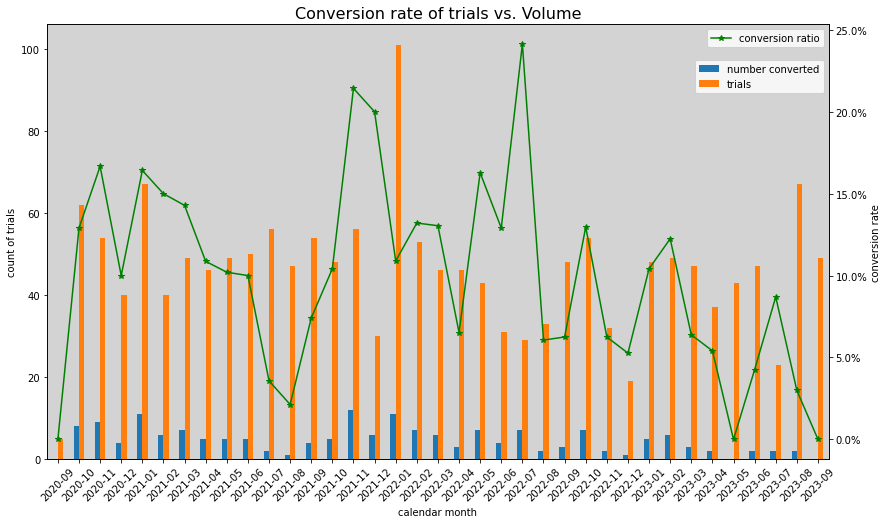

In [10]:
df['conversion_ratio'] = df['converted_cnt']/df['trials_cnt']
fig,ax1 = plt.subplots()
df.sort_values('month', ascending = True).plot(x = "month", y = ["converted_cnt","trials_cnt"], figsize = (10,6), kind = "bar", ax=ax1)
ax1.set_ylabel("count of trials")
ax1.set_xlabel("calendar month")
ax1.legend(bbox_to_anchor = (1,.93),labels = ['number converted','trials'])
ax1.set_facecolor("lightgrey")

ax2=ax1.twinx()
df.sort_values('month', ascending = True).plot(x = "month", y = "conversion_ratio", figsize = (14,8), kind = "line", marker = "*", ax=ax2, color = "green")
ax2.set_ylabel("conversion rate")
ax2.legend(labels = ['conversion ratio'])
ax1.set_xticklabels(df['month'].sort_values(ascending = True),rotation = 45)
ax1.set_title("Conversion rate of trials vs. Volume", fontsize = 16)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

## Tracking shopping habits of trial members

This involves importing a csv resultset from the mysql db, as sqlaclhemy doesn't process some of the data types properly. 
<br>**NOTE** the query (stored in membership_queries_dev.sql) also requires an updated *shopping activity log* report to be imported into the mysql db.

In [11]:
#this cannot be compiled by sqlalchemy, will require a csv import after querying in dBeaver
sql = '''
select date_add(trial_start_dt, interval  -WEEKDAY(trial_start_dt)-1 day) FirstDayOfWeek, avg(trips) avg_trips_while_trial, 
count(distinct email) trial_members, sum(case when tsh.trips > (SELECT avg(tsh_m.trips) from trialShoppingHabits tsh_m WHERE date_add(tsh_m.trial_start_dt, interval  -WEEKDAY(tsh_m.trial_start_dt)-1 day) = date_add(tsh.trial_start_dt, interval  -WEEKDAY(tsh.trial_start_dt)-1 day) AND tsh_m.relative_trial_period = 'in trial') THEN 1 ELSE 0 end) num_over_avg
-- (select max(mini.type_clean) from mem_type mini where mini.email = mt.email AND mini.type_clean not like '%trial%') 
from trialShoppingHabits tsh
where relative_trial_period = 'in trial'
group by 1
order by 1 asc;
'''

In [13]:
#unnecessary bc I can't execute this query properly in sqlalchemy
#with engine.connect() as conn:
#    shop = pd.read_sql(sql, con = conn)

In [18]:
os.getcwd()

'/home/candela/Documents/greeneHill/membershipReportsCIVI'

In [20]:
os.listdir('./membership_mysql_extracts')

['mt_ms_join-1691949177932.csv',
 'trials_shopping-1690132262897.csv',
 'target_set_trial_members-1691340912095.csv',
 'active_mems-1692142273116.csv',
 'trials_shopping_0925-1695695630675.csv',
 'mt_ms_join_WHERE-1691974925006.csv',
 'mem_type_202307041745.csv',
 'target_set_trial_members.csv',
 'trials_shopping_0925.csv',
 'bushwick_psfc_202307041227.ods',
 'trial_members_tsh_QA.csv',
 'target_trial_members.csv',
 '_WITH_others_AS_select_from_mem_type_where_type_clean_in_bushwic_202307041216.csv',
 'trials_shopping-1690242118896.csv',
 'trials_shopping_avg.csv',
 'trials_shopping-1690125122169.csv',
 'mt_ms_join_WHERE.csv',
 'trials_shopping.csv',
 'target_trial_members-1691365090521.xlsx',
 'target_trial_members-1691365090521.csv',
 'trials_shopping-1690124599459.csv',
 '_WITH_others_AS_select_from_mem_type_where_type_clean_in_bushwic_202307041227.csv']

In [21]:
shop_avg = pd.read_csv('./membership_mysql_extracts/trials_shopping_0925-1695695630675.csv')

In [22]:
max(shop_avg['FirstDayOfWeek'])

'2023-09-17'

In [24]:
shop_avg.tail()

,FirstDayOfWeek,avg_trips_while_trial,trial_members,num_over_avg
29,2023-08-20,2.0667,15,5
30,2023-08-27,2.0588,17,5
31,2023-09-03,2.0000,8,2
32,2023-09-10,2.0000,9,2
33,2023-09-17,1.2500,8,2


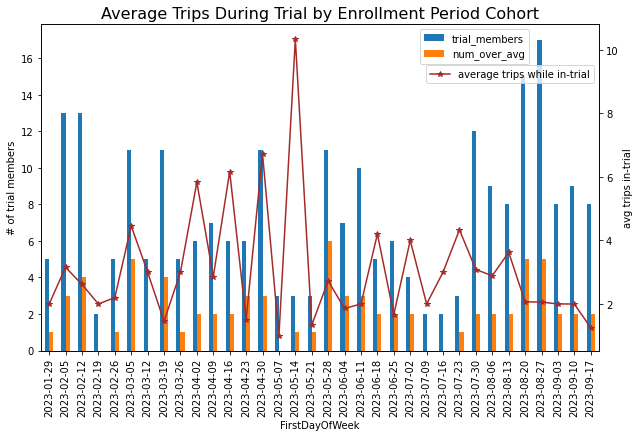

In [23]:
fig,ax1 = plt.subplots(figsize = (10,7))
shop_avg.sort_values('FirstDayOfWeek', ascending = True).plot(x = "FirstDayOfWeek", y = ["trial_members","num_over_avg"], figsize = (10,6), kind = "bar", ax=ax1)
ax1.set_ylabel('# of trial members')
ax2 = ax1.twinx()
ax2.plot(shop_avg['FirstDayOfWeek'],shop_avg['avg_trips_while_trial'], marker = '*', color = 'brown')
ax2.set_ylabel('avg trips in-trial')
ax1.set_title('Average Trips During Trial by Enrollment Period Cohort', fontsize = 16)
ax2.legend(bbox_to_anchor = (1,.89), labels = ['average trips while in-trial'])
ax1.legend(bbox_to_anchor = (.883,1))
